In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from engine.models.distance import DistanceMatrix
from engine.models.movie import Movie
from engine.models.prediction import Prediction
import pandas as pd

In [3]:
folder = '/media/mariam/Files/ran/clacket-save'
matrix = DistanceMatrix(folder)
matrix.load()

In [4]:
movies = ['1'] + list(matrix.matrix['1'].keys())

In [5]:
import sys
import random
from math import ceil, sqrt

DATASET = 'dataset/expanded_movies.txt'

def get_year(movie_id):
    ret = None
    with open(DATASET) as dataset:
        for movie_line in dataset:
            split = movie_line.split('|')
            id, year = split[0], split[2]
            if id == movie_id:
                if year != 'N/A':
                    ret = int(year)
                else:
                    break
    return ret

def crono_label(start, end):
    return '{0}_{1}'.format(start, end)

def older(other_movie, base_movie):
    # return true if other_movie is older than base_movie
    return get_year(base_movie) > get_year(other_movie)
        
def testing_set(percentage, movie_ids):
    testing_size = ceil(percentage * len(movie_ids))
    pool = random.sample(movie_ids, testing_size)
    return (pool, pool)

def cronological_set(start, end):
    pool = []
    new = []
    with open(DATASET) as dataset:
        for movie_line in dataset:
            split = movie_line.split('|')
            id, year = split[0], split[2]
            if year != 'N/A':
                year = int(year)
                if year <= end:
                    pool.append(id)
                    if year >= start:
                        new.append(id)
    return (pool, new)

def k_nearest(matrix, id, testing_set, k=5, cronological=False):
    distances = matrix.get_some(id, testing_set)
    start = 1 if id in testing_set else 0  # start from 1 because 0 will always be itself if included
    nearest_k = sorted(distances, key=lambda x: x[1])[start:k+start]
    return [x[0] for x in nearest_k] if not cronological else [x[0] for x in nearest_k if older(x[0], id)]

def k_nearest_all(pool, testing_set, matrix, k=5, cronological=False, **kwargs):
    i = 1
    n = len(testing_set)
    for movie_id in testing_set:
        sys.stdout.write('\rCalculating nearest {0} for {1} out of {2}..'.format(k, i, n))
        sys.stdout.flush()
        try:
            movie = Movie.load(folder, movie_id)
            nearest = k_nearest(matrix, movie_id, pool, k=k, cronological=cronological)
            predictions = Prediction(predicted_type=kwargs.get('predicted_type', 'mean'))
            for near_movie_id in nearest:
                near_movie = Movie.load(folder, near_movie_id)
                predictions.extend(near_movie.ratings)
            if not hasattr(movie, 'predictions') or movie.predictions is None:
                movie.predictions = {}
            if cronological:
                start, end = kwargs.get('start'), kwargs.get('end')
                label = crono_label(start, end)
                if label not in movie.predictions:
                    movie.predictions[label] = {}
                if k not in movie.predictions[label]:
                    movie.predictions[label][k] = {}
                movie.predictions[label][k]['list'] = predictions.list
                movie.predictions[label][k]['users'] = predictions.users
            else:
                if n not in movie.predictions:
                    movie.predictions[n] = {}
                if k not in movie.predictions[n] or 'list' not in movie.predictions[n][k]:
                    movie.predictions[n][k] = {}
                movie.predictions[n][k]['list'] = predictions.list
                movie.predictions[n][k]['users'] = predictions.users
            movie.save(folder)
        except EOFError:
            print('Could not load movie: {0}'.format(movie_id))
        i += 1


def get_predictions(movie_id, cronological=False, **kwargs):
    movie = Movie.load(folder, movie_id)
    k = kwargs.get('k', 1)
    predictions = None
    if cronological:
        start, end = kwargs.get('start'), kwargs.get('end')
        label = crono_label(start, end)
        predictions = movie.predictions[label]
    else:
        n = kwargs.get('n', 9399)
        predictions = movie.predictions[n]
    movie.ratings.set_index('user_id', inplace=True)
    return predictions[k]['list'].join(movie.ratings, how='inner', on='user_id')

def measure_predictions(movie_id, min, k=1, n=9399, cronological=False, **kwargs):
    predictions = get_predictions(movie_id, cronological=cronological, k=k, n=n, **kwargs)
    intersection = predictions[predictions['mean_rating'] >= min]
    hits = intersection[intersection['rating'] >= min].shape[0]
    misses = intersection[intersection['rating'] < min].shape[0]
    absolute_error = abs(intersection['rating'] - intersection['mean_rating'])
    delta = pow(predictions['rating'] - predictions['mean_rating'], 2)
    n_add = delta.size
    sum_squared = delta.sum() if not delta.empty else 0
    return (hits, misses, absolute_error, n_add, sum_squared)

def all_predictions(testing_set, min=4, k=5, cronological=False, **kwargs):
    hits, misses = 0,0
    n = len(testing_set)
    ratings, sum_squared_total = 0,0
    absolute_error = pd.Series()
    for movie_id in testing_set:
        sys.stdout.write('\rTesting predictions for movie_id={0}.. (for k={1})'.format(movie_id, k))
        sys.stdout.flush()
        m_hits, m_misses, m_absolute_error, n_add, sum_squared = measure_predictions(movie_id, min, k, n, cronological=cronological, **kwargs)
        hits += m_hits
        misses += m_misses
        absolute_error = absolute_error.append(m_absolute_error)
        ratings += n_add
        sum_squared_total += sum_squared
    divided = sum_squared_total/ratings if ratings > 0 else 0
    rmse = sqrt(divided)
    return (hits, misses, absolute_error.mean(axis=0), rmse)

def perc(predictions):
    hits, misses, mean_absolute_error, rmse = predictions
    total = hits + misses
    hits_p = (hits/total) * 100
    misses_p = (misses/total) * 100
    return (hits, hits_p, misses, misses_p, mean_absolute_error, rmse)

def predict(pool, testing_set, matrix, ks=[5], print_only=False, mins=[3, 4], cronological=False, **kwargs):
    if not print_only:
        for k in ks:
            k_nearest_all(pool, testing_set, matrix, k=k, cronological=cronological, **kwargs)
    results_matrix = {'k': []}
    for minimum in mins:
        results_matrix['total_hits_{0}'.format(minimum)] = []
        results_matrix['total_misses_{0}'.format(minimum)] = []
        results_matrix['perc_hits_{0}'.format(minimum)] = []
        results_matrix['perc_misses_{0}'.format(minimum)] = []
        results_matrix['mean_absolute_error_{0}'.format(minimum)] = []
        results_matrix['rmse_{0}'.format(minimum)] = []
    for k in ks:
        sys.stdout.write('\rTesting predictions for k={0}..'.format(k))
        sys.stdout.flush()
        results_matrix['k'].append(k)
        mean_absolute_error = 0
        for minimum in mins:
            predictions = all_predictions(testing_set, min=minimum, k=k, cronological=cronological, **kwargs)
            hits, hits_p, misses, misses_p, mean_absolute_error, rmse_val = perc(predictions)
            results_matrix['total_hits_{0}'.format(minimum)].append(hits)
            results_matrix['perc_hits_{0}'.format(minimum)].append(hits_p)
            results_matrix['total_misses_{0}'.format(minimum)].append(misses)
            results_matrix['perc_misses_{0}'.format(minimum)].append(misses_p)
            results_matrix['mean_absolute_error_{0}'.format(minimum)].append(mean_absolute_error)
            results_matrix['rmse_{0}'.format(minimum)].append(rmse_val)
    print('Done.')
    return pd.DataFrame(data=results_matrix)

In [8]:
import matplotlib.pyplot as plt
import pylab

def plot(df, size_str, save_str, prefix='', y=['perc_hits_3', 'perc_hits_4', 'perc_hits_5']):
    df.plot.bar(x='k', y=y, ylim=(0,100))
    plt.title('{0}'.format(size_str))
    saved = pylab.savefig('Results_{0}{1}.png'.format(prefix, save_str))
    df.to_pickle('{0}.pkl'.format(save_str))
    plt.show()

In [14]:
# t_set2 = testing_set(0.7, movies)
# df2 = predict(t_set2, matrix, ks=[1,2,3,4])

Testing predictions for movie_id=7435.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


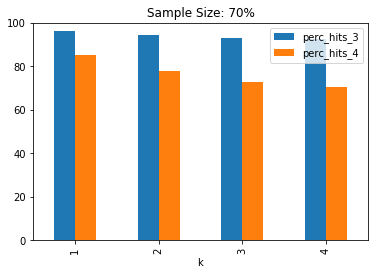

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.346605,96.275257,85.333371,3.724743,14.666629,3345983,2965705,129451,509729
1,2,0.509732,94.297790,77.730753,5.702210,22.269247,5032128,4148041,304294,1188381
2,3,0.602748,93.074024,72.981694,6.925976,27.018306,6831800,5356987,508379,1983192
3,4,0.647675,92.509345,70.478780,7.490655,29.521220,8567296,6527044,693710,2733962


In [9]:
# plot(df2, '70%')
# df2

In [10]:
# t_set3 = testing_set(0.5, movies)
# df3 = predict(t_set3, matrix, ks=[1,2,3,4])

Testing predictions for movie_id=4774.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


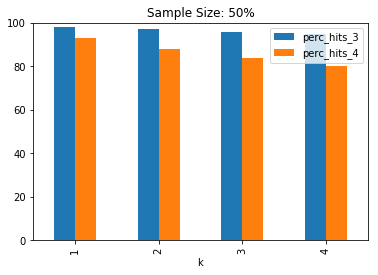

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.155932,98.373699,93.285899,1.626301,6.714101,4586718,4349497,75827,313048
1,2,0.272065,97.088543,88.082030,2.911457,11.917970,5446210,4940987,163319,668542
2,3,0.358565,96.054001,83.878653,3.945999,16.121347,6290809,5493416,258433,1055826
3,4,0.433844,95.144237,80.258524,4.855763,19.741476,7207548,6079897,367843,1495494


In [11]:
# plot(df3, '50%')
# df3

In [12]:
# t_set4 = testing_set(0.3, movies)
# df4 = predict(t_set4, matrix, ks=[1,2,3,4])

Testing predictions for movie_id=8427.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


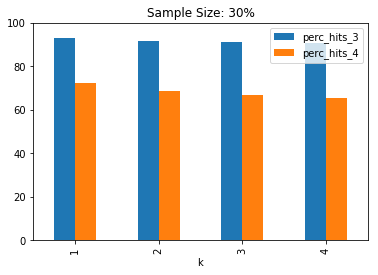

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.621813,92.896185,72.595214,7.103815,27.404786,1193938,933022,91301,352217
1,2,0.703641,91.854843,68.741113,8.145157,31.258887,1943090,1454144,172302,661248
2,3,0.734602,91.279091,66.967245,8.720909,33.032755,2529842,1856028,241704,915518
3,4,0.762192,90.818529,65.703862,9.181471,34.296138,3404892,2463314,344224,1285802


In [13]:
# plot(df4, '30%')
# df4

In [17]:
## since all are saved, run without calculating distances to get MAE for specific mins
# df1_ = predict(t_set1, matrix, ks=[1,2,3,4], print_only=True)

Testing predictions for movie_id=10894.. (for k=4)Done.


In [18]:
# df2_ = predict(t_set2, matrix, ks=[1,2,3,4], print_only=True)

Testing predictions for movie_id=7435.. (for k=4))Done.


In [19]:
# df3_ = predict(t_set3, matrix, ks=[1,2,3,4], print_only=True)

Testing predictions for movie_id=4774.. (for k=4))Done.


In [20]:
# df4_ = predict(t_set4, matrix, ks=[1,2,3,4], print_only=True)

Testing predictions for movie_id=8427.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


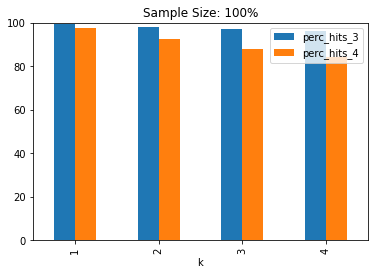

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.061351,99.393912,97.516274,0.606088,2.483726,11199698,10988126,68294,279866
1,2,0.171410,98.317247,92.526383,1.682753,7.473617,12690337,11942879,217202,964660
2,3,0.263819,97.307834,88.194483,2.692166,11.805517,14398646,13050143,398360,1746863
3,4,0.341101,96.386327,84.523295,3.613673,15.476705,16343309,14331808,612736,2624237


In [22]:
# plot(df1_, '100%', prefix='new')
# df1_

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


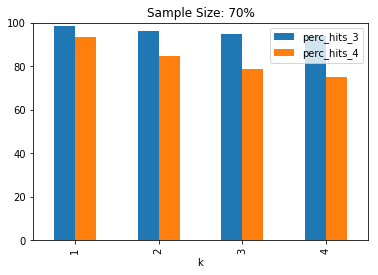

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.160895,98.385255,93.526639,1.614745,6.473361,3995377,3798071,65574,262880
1,2,0.347770,96.382824,84.871169,3.617176,15.128831,5323527,4687702,199788,835613
2,3,0.475052,94.847805,78.886445,5.152195,21.113555,7043674,5858337,382617,1567954
3,4,0.547040,93.839185,75.221076,6.160815,24.778924,8520400,6829915,559389,2249874


In [23]:
plot(df2_, '70%', prefix='new')
df1_

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


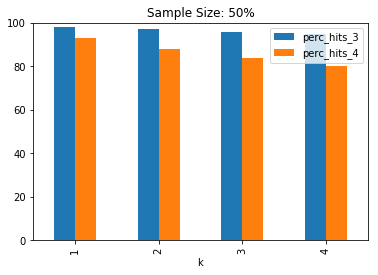

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.155932,98.373699,93.285899,1.626301,6.714101,4586718,4349497,75827,313048
1,2,0.272065,97.088543,88.082030,2.911457,11.917970,5446210,4940987,163319,668542
2,3,0.358565,96.054001,83.878653,3.945999,16.121347,6290809,5493416,258433,1055826
3,4,0.433844,95.144237,80.258524,4.855763,19.741476,7207548,6079897,367843,1495494


In [24]:
plot(df3_, '50%', prefix='new')
df3_

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


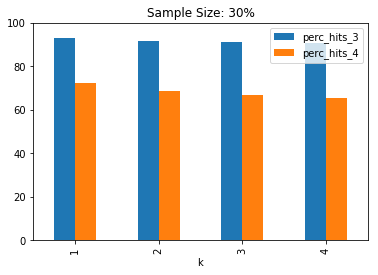

,k,mean_absolute_error,perc_hits_3,perc_hits_4,perc_misses_3,perc_misses_4,total_hits_3,total_hits_4,total_misses_3,total_misses_4
0,1,0.621813,92.896185,72.595214,7.103815,27.404786,1193938,933022,91301,352217
1,2,0.703641,91.854843,68.741113,8.145157,31.258887,1943090,1454144,172302,661248
2,3,0.734602,91.279091,66.967245,8.720909,33.032755,2529842,1856028,241704,915518
3,4,0.762192,90.818529,65.703862,9.181471,34.296138,3404892,2463314,344224,1285802


In [25]:
plot(df4_, '30%', prefix='new')
df4_

In [33]:
start2, end2 = 2005, 2005
pool2, test2 = cronological_set(start2, end2)
df2c = predict(pool2, test2, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=start2, end=end2)

Testing predictions for movie_id=17405.. (for k=4)Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


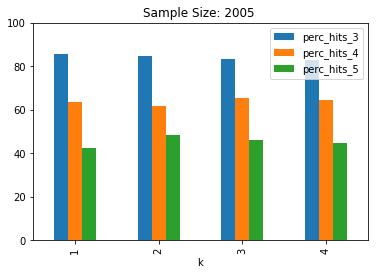

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.858263,0.812808,1.134615,85.714286,63.546798,42.307692,14.285714,36.453202,57.692308,1.662921,1.662921,1.662921,1530,258,22,255,148,30
1,2,0.860475,0.821229,0.984848,84.714702,61.638734,48.484848,15.285298,38.361266,51.515152,1.636469,1.636469,1.636469,2034,331,32,367,206,34
2,3,0.890231,0.839406,0.960784,83.374778,65.317139,46.405229,16.625222,34.682861,53.594771,1.631768,1.631768,1.631768,2347,484,71,468,257,82
3,4,0.905530,0.848635,0.994444,82.916392,64.764268,45.000000,17.083608,35.235732,55.000000,1.630931,1.630931,1.630931,2519,522,81,519,284,99


In [34]:
plot(df2c, '2005 ', y=['perc_hits_3', 'perc_hits_4', 'perc_hits_5'])
df2c

In [35]:
start3, end3 = 2000, 2006
pool3, test3 = cronological_set(start3, end3)
df3c = predict(pool3, test3, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=start3, end=end3)

Testing predictions for movie_id=14073.. (for k=4)Done.


In [36]:
start4, end4 = 2000, 2006
pool4, test4 = cronological_set(start4, end4)
df4c = predict(pool4, test4, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=start4, end=end4, predicted_type='max')

Testing predictions for movie_id=14073.. (for k=4)Done.


In [37]:
start5, end5 = 2000, 2006
pool5, test5 = cronological_set(start5, end5)
df5c = predict(pool5, test5, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=start5, end=end5, predicted_type='min')

Testing predictions for movie_id=14073.. (for k=4)Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


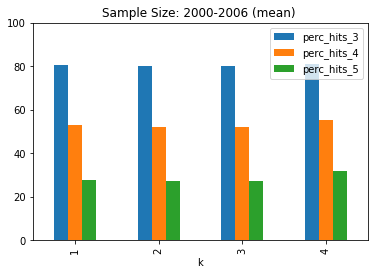

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.966602,1.055098,1.311278,80.646796,53.074941,27.585072,19.353204,46.925059,72.414928,1.440896,1.440896,1.440896,71620,31509,6704,17187,27858,17599
1,2,0.978462,1.072189,1.327134,80.154582,52.344824,27.265199,19.845418,47.655176,72.734801,1.450948,1.450948,1.450948,86490,37325,7902,21414,33981,21080
2,3,0.981059,1.074124,1.327868,80.124622,52.351212,27.275189,19.875378,47.648788,72.724811,1.450599,1.450599,1.450599,98756,42750,9066,24497,38910,24173
3,4,0.951755,1.024593,1.214977,81.171924,55.169969,31.863032,18.828076,44.830031,68.136968,1.425957,1.425957,1.425957,112803,52145,13046,26165,42372,27898


In [38]:
plot(df3c, '2000-2006 (mean) ', y=['perc_hits_3', 'perc_hits_4', 'perc_hits_5'], prefix='mean')
df3c

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


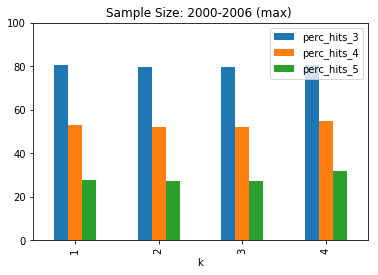

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.966602,1.055098,1.311278,80.646796,53.074941,27.585072,19.353204,46.925059,72.414928,1.440896,1.440896,1.440896,71620,31509,6704,17187,27858,17599
1,2,0.980252,1.073133,1.327654,79.885179,52.325435,27.237367,20.114821,47.674565,72.762633,1.452957,1.452957,1.452957,86689,37341,7913,21828,34022,21139
2,3,0.984099,1.076885,1.329310,79.755080,52.309346,27.206829,20.244920,47.690654,72.793171,1.453988,1.453988,1.453988,99059,42822,9083,25145,39041,24302
3,4,0.955422,1.028053,1.216970,80.760998,55.125354,31.770593,19.239002,44.874646,68.229407,1.429821,1.429821,1.429821,113193,52309,13079,26965,42582,28088


In [39]:
plot(df4c, '2000-2006 (max) ', y=['perc_hits_3', 'perc_hits_4', 'perc_hits_5'], prefix='max')
df4c

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


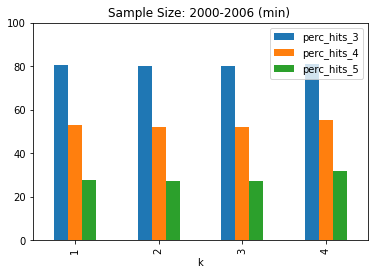

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.966602,1.055098,1.311278,80.646796,53.074941,27.585072,19.353204,46.925059,72.414928,1.440896,1.440896,1.440896,71620,31509,6704,17187,27858,17599
1,2,0.978246,1.072270,1.327134,80.155346,52.354485,27.265199,19.844654,47.645515,72.734801,1.452153,1.452153,1.452153,86478,37301,7902,21410,33946,21080
2,3,0.980278,1.074199,1.327868,80.157029,52.371900,27.275189,19.842971,47.628100,72.724811,1.452248,1.452248,1.452248,98723,42703,9066,24439,38835,24173
3,4,0.950763,1.024658,1.214977,81.215828,55.197125,31.863032,18.784172,44.802875,68.136968,1.428390,1.428390,1.428390,112743,52068,13046,26076,42263,27898


In [40]:
plot(df5c, '2000-2006 (min) ', y=['perc_hits_3', 'perc_hits_4', 'perc_hits_5'], prefix='min')
df5c

Testing predictions for movie_id=3912.. (for k=5))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


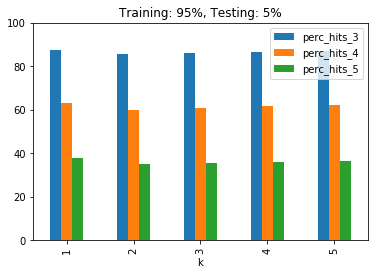

In [9]:
pool1, t_set1 = testing_set(0.05, movies)
df1 = predict(pool1, t_set1, matrix, ks=[1,2,3,4,5], mins=[3,4,5])
plot(df1, 'Training: 95%, Testing: 5%', '95_5')

In [10]:
df1

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.847360,0.852952,1.051709,87.409843,63.115154,38.029820,12.590157,36.884846,61.970180,1.316792,1.316792,1.316792,248320,106166,20762,35767,62044,33832
1,2,0.854858,0.893983,1.120981,85.787812,59.821742,35.105931,14.212188,40.178258,64.894069,1.292562,1.292562,1.292562,513875,211154,39702,85132,141818,73390
2,3,0.836731,0.872278,1.090193,86.401016,60.900261,35.443596,13.598984,39.099739,64.556404,1.265164,1.265164,1.265164,770348,315886,57940,121248,202808,105531
3,4,0.826475,0.855845,1.068844,86.808828,61.851999,36.185260,13.191172,38.148001,63.814740,1.252930,1.252930,1.252930,905897,369990,66206,137657,228196,116758
4,5,0.823205,0.850553,1.062672,87.068347,62.422540,36.313943,12.931653,37.577460,63.686057,1.249659,1.249659,1.249659,967877,391046,68824,143752,235404,120701


In [11]:
df19 = pd.read_pickle('10_90.pyc')

/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


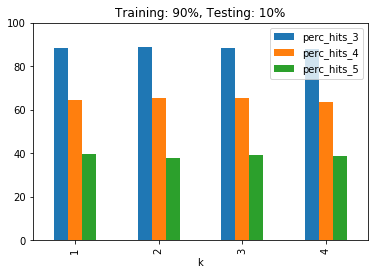

In [12]:
plot(df19, 'Training: 90%, Testing: 10%', '90_10')

Testing predictions for movie_id=15011.. (for k=4)Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


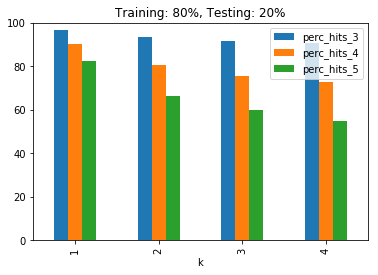

In [21]:
pool2, t_set2 = testing_set(0.2, movies)
df2 = predict(pool2, t_set2, matrix, ks=[1,2,3,4], mins=[3,4,5])
plot(df2, 'Training: 80%, Testing: 20%', '80_20_new')

In [15]:
df2

,k,mean_absolute_error_3,mean_absolute_error_4,mean_absolute_error_5,perc_hits_3,perc_hits_4,perc_hits_5,perc_misses_3,perc_misses_4,perc_misses_5,rmse_3,rmse_4,rmse_5,total_hits_3,total_hits_4,total_hits_5,total_misses_3,total_misses_4,total_misses_5
0,1,0.250936,0.242842,0.271889,96.559781,89.930340,83.253134,3.440219,10.069660,16.746866,0.700751,0.700751,0.700751,1605485,967985,356753,57200,108387,71763
1,2,0.445686,0.443283,0.505147,93.706914,81.044680,69.248031,6.293086,18.955320,30.751969,0.918352,0.918352,0.918352,2363279,1307027,420294,158711,305697,186646
2,3,0.546595,0.546344,0.632274,92.398497,76.842884,61.368781,7.601503,23.157116,38.631219,1.006340,1.006340,1.006340,3090556,1633108,474431,254256,492148,298651
3,4,0.602603,0.591459,0.676588,91.731032,75.332081,58.620780,8.268968,24.667919,41.379220,1.056594,1.056594,1.056594,3694715,1876434,513732,333055,614449,362633


Testing predictions for movie_id=6858.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


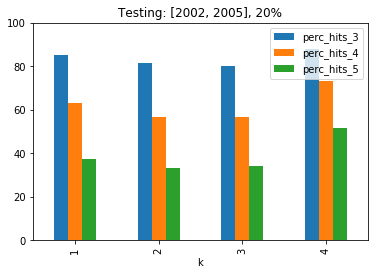

In [16]:
pool, t_set = cronological_set(2002, 2006)
df = predict(pool, t_set, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=2003, end=2006)
plot(df, 'Testing: [2002, 2005], 20%', '2002_2005')

Testing predictions for movie_id=6091.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


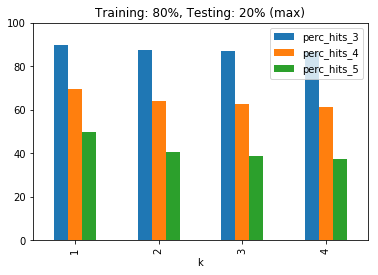

In [17]:
pool22, t_set22 = testing_set(0.2, movies)
df22 = predict(pool22, t_set22, matrix, ks=[1,2,3,4], mins=[3,4,5], predicted_type='max')
plot(df22, 'Training: 80%, Testing: 20% (max)', '80_20_max')

Testing predictions for movie_id=9208.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


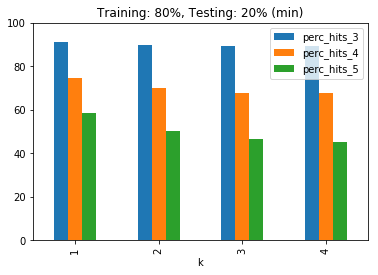

In [18]:
pool23, t_set23 = testing_set(0.2, movies)
df23 = predict(pool23, t_set23, matrix, ks=[1,2,3,4], mins=[3,4,5], predicted_type='min')
plot(df23, 'Training: 80%, Testing: 20% (min)', '80_20_min')

Testing predictions for movie_id=6858.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


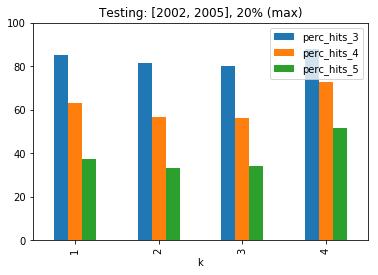

In [19]:
pool01, t_set01 = cronological_set(2002, 2006)
df01 = predict(pool01, t_set01, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=2003, end=2006, predicted_type='max')
plot(df01, 'Testing: [2002, 2005], 20% (max)', '2002_2005_max')

Testing predictions for movie_id=6858.. (for k=4))Done.


/home/mariam/code/clacket/clacket/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


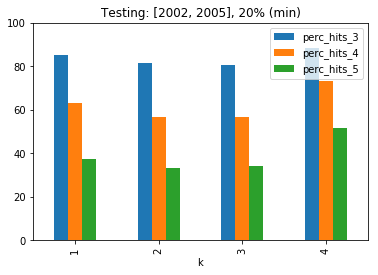

In [20]:
pool02, t_set02 = cronological_set(2002, 2006)
df02 = predict(pool02, t_set02, matrix, ks=[1,2,3,4], mins=[3,4,5], cronological=True, start=2003, end=2006, predicted_type='min')
plot(df02, 'Testing: [2002, 2005], 20% (min)', '2002_2005_min')